# Movie Investigations for Microsoft - Project1

- Student name: **Aysu Erdemir**
- Student pace: **Data Science Flex**
- Scheduled project review date/time: **May 13, 2023 1pm** 
- Instructor name: **Claude Fried**
- Cohort lead / project reviewer: **Abhineet Kulkarni**

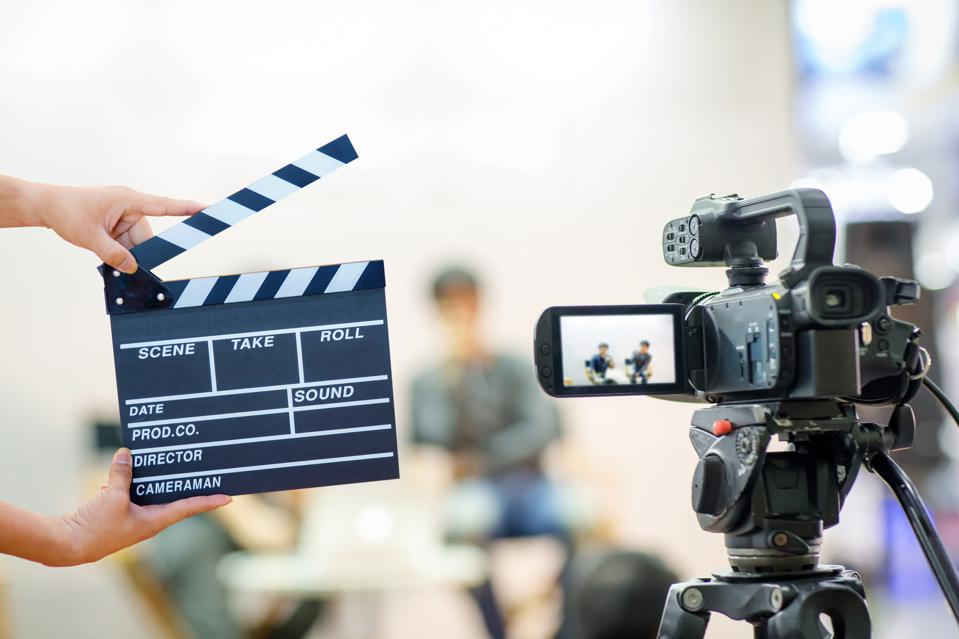

In [1]:
from IPython.display import Image
Image(filename='images/filmmaking.jpeg')

## Overview

This project analyzes movie data to provide insights and recommendations about the kind of movies Microsoft should make for their new movie studio. 

## Business Problem

Microsoft has decided to create a new movie studio, but they need information about what kind of movies are doing best financially. I will be performing exploratory analyses on data from past movies to help Microsoft decide what kind of movies to create. 

***
The process unfolds in this manner:

1. Defining reliable measure(s) for assessing profitability of a movie using `worldwide_gross`, `production_budget` or audience `averageratings`. 
2. Looking into various movie characteristics of `genre`, `director`, `release_month` and `runtime_minutes` in relation to profitability.
3. Making suggestions about the kind of movies to be made based on the findings.
    - What genres of movies to make?
    - Which directors to work with?
    - When to release the movie?
    - Which movie length to focus on?


## Data Understanding

I will be using:
1. A dataset from [IMDb](https://www.imdb.com/) which involves 4 tables and 140416 Distinct Movies:
    - movie_basics which involves  title, year, runtime, and genre information for each movie.
    - movie_ratings which involves average rating.
    - directors which involves director ID for each movie.
    - persons which allows us to link director IDs to their names. 

The variables representing movie characteristics will be derived from this database. 

2. A dataset from [The Numbers](https://www.the-numbers.com/) which involves  `production_budget` as well as `worldwide_gross` information of 5698 distinct movies.

The measures for assesing profitability will be mainly derived from this datasheet. 



In [2]:
# Import standard packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline

Load the IMDB database file (im.db) using SQLite and explore the tables:

In [3]:
# Read the tables using sqlite
import sqlite3 
conn= sqlite3.connect('zippedData/im.db')

In [4]:
# Read the table movie_basics
movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics;
""", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [6]:
movie_basics.nunique()

movie_id           146144
primary_title      136071
original_title     137773
start_year             19
runtime_minutes       367
genres               1085
dtype: int64

In [7]:
movie_basics['primary_title'].duplicated().sum()
# 10073 movie titles are duplicated despite having different movie IDs

10073

In [8]:
movie_basics[movie_basics['primary_title'].duplicated()].head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
706,tt10022974,Nemesis,Nemesis,2019,NaN,"Action,Thriller"
948,tt10064536,Untitled Disney Marvel Film,Untitled Disney Marvel Film,2022,NaN,Action
949,tt10064558,Untitled Marvel Film,Untitled Marvel Film,2021,NaN,Action
1478,tt10127292,Plushtubers: The Apocalypse,Plushtubers: The Apocalypse,2019,NaN,"Action,Adventure"
1622,tt10148772,Indemnity,Indemnity,2018,45.0,Thriller


In [9]:
movie_basics[movie_basics['primary_title'] == 'Nemesis']
# In some cases same movie name was used for different movies/versions.

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
280,tt0800353,Nemesis,Nemesis,2010,83.0,Drama
706,tt10022974,Nemesis,Nemesis,2019,NaN,"Action,Thriller"
136440,tt8695086,Nemesis,Nemesis,2019,78.0,Thriller


In [10]:
movie_basics[movie_basics['primary_title'] == 'Untitled Disney Marvel Film']
# Same movie was repeated with different movie_ids. 

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
821,tt10042446,Untitled Disney Marvel Film,Untitled Disney Marvel Film,2022,NaN,Action
948,tt10064536,Untitled Disney Marvel Film,Untitled Disney Marvel Film,2022,NaN,Action
130616,tt8097016,Untitled Disney Marvel Film,Untitled Disney Marvel Film,2022,NaN,Action


ISSUE and SOLUTION:
- When the same movie name was used for different movies/versions, we need to take "year" into consideration to tell them apart.
- When the same movie was just repeated with different movie_ids, we need to drop those duplicated values. 

In [11]:
movie_basics.describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [12]:
print(movie_basics[movie_basics['runtime_minutes'] == 51420])
print(movie_basics[movie_basics['start_year'] == 2115])
# Indeed there is a film with a runtime of 857 hours which is the longest film ever made.
# It seems like IMDB is also showing movies that are currently under development.

         movie_id primary_title original_title  start_year  runtime_minutes  \
132389  tt8273150     Logistics      Logistics        2012          51420.0   

             genres  
132389  Documentary  
        movie_id primary_title original_title  start_year  runtime_minutes  \
89506  tt5174640     100 Years      100 Years        2115              NaN   

      genres  
89506  Drama  


**Issues to consider about movie_basics:**
- `movie_id` is the primary key, there are 146.144 movies. 
- 10073 `primary_title` are duplicated despite having different `movie_id`. 
- Use `primary_title` instead of `original_title` since it is in English.
- Since some movies have multiple `genres`, split the text and assign them to seperate rows.

In [13]:
movie_ratings = pd.read_sql("""
SELECT *
FROM movie_ratings;
""", conn)

movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [14]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [15]:
# suppress scientific notation output while using .describe()
movie_ratings.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


In [16]:
movie_ratings['movie_id'].duplicated().sum()

0

In [17]:
movie_ratings[movie_ratings['numvotes']==1841066]

,movie_id,averagerating,numvotes
63498,tt1375666,8.8,1841066


In [18]:
# Inception indeed has been voted for 1841066 times. 
movie_basics[movie_basics['movie_id']=='tt1375666']

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
7066,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi"


**Issues to consider about movie_ratings:**
- `movie_id` is the primary key, there are 73856 movies, about half the size of movies in movie_basics. 
- We can use `averagerating` as an indication of how much people like each movie.

In [19]:
directors = pd.read_sql("""
SELECT *
FROM directors;
""", conn)

directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [20]:
directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [21]:
directors.nunique()

movie_id     140417
person_id    109253
dtype: int64

In [22]:
print(directors.duplicated().sum())
print(directors['movie_id'].duplicated().sum())
print(directors['person_id'].duplicated().sum())
# There are 127.639 duplicated rows, 150.757 duplicated movies and 181.921 duplicated persons.

127639
150757
181921


In [23]:
directors[directors.duplicated()].sort_values(by= 'movie_id').head(10)

,movie_id,person_id
222428,tt0063540,nm0712540
222429,tt0063540,nm0712540
222430,tt0063540,nm0712540
68345,tt0069049,nm0000080
252268,tt0100275,nm0749914
252267,tt0100275,nm0765384
276830,tt0146592,nm1030585
217424,tt0162942,nm1207262
217423,tt0162942,nm1207262
19674,tt0176694,nm0417757


**Issues to consider about directors:**
- `movie_id` is the primary key, there are 291.174 movies, however about only the half (140.417) are unique entries.
- There are 127.639 duplicated rows, 150.757 duplicated movies and 181.921 duplicated persons. 
- Some of the duplicated `movie id`s and `person id`s are because same director have directed more than 1 movie and some movies probably have multiple directors. 
- Need to drop the duplicated rows later when looking into factors other than director. 

In [24]:
# In order to extract director name we need persons table. 
persons = pd.read_sql("""
SELECT *
FROM persons;
""", conn)

persons.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [25]:
persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


In [26]:
print(persons['person_id'].duplicated().sum())
print(persons['primary_name'].duplicated().sum())

0
29445


In [27]:
persons[persons['primary_name'].duplicated()].sort_values(by = 'primary_name').head(8)
# Same name has been coded under different person ID's and profession probaby due to the 
# different roles they took in different movies.

,person_id,primary_name,birth_year,death_year,primary_profession
279631,nm4062141,A. Venkatesh,NaN,NaN,"director,actor,writer"
156216,nm1701176,A. Venkatesh,NaN,NaN,"cinematographer,camera_department,editor"
387377,nm8956236,A. Venkatesh,NaN,NaN,producer
436444,nm6758318,A.J. Khan,NaN,NaN,producer
565680,nm7645047,A.K. Azad,NaN,NaN,"music_department,composer"
255710,nm3714249,AJ Perez,NaN,NaN,"producer,writer,actor"
262683,nm3942577,Aadhi,NaN,NaN,"actor,music_department,soundtrack"
446609,nm6832961,Aadhi,NaN,NaN,actor


In [28]:
persons['primary_profession'].str.contains('director').sum()

146033

**Issues to consider about persons:**
- `person_id` is the primary key, there are 606.648 people entries, however only about 146.033 of them are "directors". 
- We only need `primary_name` information as well as `person_id` to link this table to directors table.
- Same name has been coded under different person ID's and profession probably due to different roles in different movies. Therefore there are duplicated entries. 

**Extract a comprehensive imdb dataframe from the database using 4 tables:**

- movie_basics - to get title, year, runtime, and genre information for each movie. 
- movie_ratings - to get average rating and number of votes
- directors - to get the director ID information for each movie 
- persons - to be able to link the directors to their names

In [29]:
length_movie_id = [len(x['movie_id']) for x in [movie_basics, movie_ratings, directors]]
length_movie_id

[146144, 73856, 291174]

In [30]:
# Left join movie_ratings because we want to keep all records regardless they have a rating. 
# Left join directors because we want to keep all records regardless they have a director. 
# Inner join persons because we do NOT want the people who are NOT directors in the dataset. 

imdb = pd.read_sql("""
SELECT DISTINCT movie_id, 
       primary_title,
       start_year,
       runtime_minutes,
       genres,
       averagerating,
       numvotes,
       person_id,
       primary_name as director_name
FROM movie_basics
LEFT JOIN movie_ratings
    USING(movie_id)
LEFT JOIN directors  
    USING(movie_id)
JOIN persons
    USING(person_id)
ORDER BY (movie_id)

""", conn)

print(imdb.shape)

imdb.head()

(163533, 9)


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,nm0712540,Harnam Singh Rawail
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43.0,nm0002411,Mani Kaul
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,nm0000080,Orson Welles
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,nm0611531,Hrishikesh Mukherjee
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0749914,Raoul Ruiz


In [31]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163533 entries, 0 to 163532
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         163533 non-null  object 
 1   primary_title    163533 non-null  object 
 2   start_year       163533 non-null  int64  
 3   runtime_minutes  130938 non-null  float64
 4   genres           159789 non-null  object 
 5   averagerating    86030 non-null   float64
 6   numvotes         86030 non-null   float64
 7   person_id        163533 non-null  object 
 8   director_name    163533 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 11.2+ MB


In [32]:
imdb.nunique()
# There are 140,416 unique movie ID's 

movie_id           140416
primary_title      131121
start_year             18
runtime_minutes       360
genres               1076
averagerating          91
numvotes             7347
person_id          109251
director_name      106757
dtype: int64

In [33]:
imdb[imdb['primary_title'].duplicated()].head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
5,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0765384,Valeria Sarmiento
10,tt0139613,O Silêncio,2012,NaN,"Documentary,History",NaN,NaN,nm0518037,António Loja Neves
24,tt0253093,Gangavataran,2018,134.0,None,6.6,8.0,nm0679610,Dhundiraj Govind Phalke
32,tt0283440,Short Time Heroes,2015,45.0,Sci-Fi,6.6,16.0,nm1549344,Roman Gonther
40,tt0312305,Quantum Quest: A Cassini Space Odyssey,2010,45.0,"Adventure,Animation,Sci-Fi",5.1,287.0,nm1004541,Harry 'Doc' Kloor


In [34]:
imdb[imdb['primary_title'] == 'The Wandering Soap Opera']
# Duplications present due to multiple directors

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0749914,Raoul Ruiz
5,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0765384,Valeria Sarmiento


In [35]:
imdb[imdb[['primary_title', 'start_year', 'genres', 'director_name']].duplicated()].head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
1307,tt10095336,Our Godfather,2019,NaN,Documentary,NaN,NaN,nm2432785,Andrew Meier
1578,tt10127292,Plushtubers: The Apocalypse,2019,NaN,"Action,Adventure",NaN,NaN,nm10594636,Valarie Holmes
2350,tt10224422,Olanda,2019,154.0,Documentary,NaN,NaN,nm2375939,Bernd Schoch
2403,tt10230042,Rok Sako To Rok Lo,2018,NaN,Comedy,NaN,NaN,nm10641569,Kashif Saleem
2421,tt10230622,Aitebaar,2017,80.0,Comedy,NaN,NaN,nm10635731,Kashif Saleem


In [36]:
imdb[imdb['primary_title'] == 'Plushtubers: The Apocalypse']
# Duplications present also due to different movie_ids from the 1st IMDB table. 

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
1577,tt10127274,Plushtubers: The Apocalypse,2019,NaN,"Action,Adventure",NaN,NaN,nm10594636,Valarie Holmes
1578,tt10127292,Plushtubers: The Apocalypse,2019,NaN,"Action,Adventure",NaN,NaN,nm10594636,Valarie Holmes


**DROP duplicate movies with different IDs**:
Because the first table from IMDb database included duplicated movies with different movie_ids, find those movies and drop them:

In [37]:
# Find those cases where only movie_id was different:
to_drop = imdb[imdb[['primary_title', 'start_year', 'genres', 'director_name']].duplicated()]
len(to_drop)

369

In [38]:
imdb.drop(to_drop.index, axis=0, inplace=True)

In [39]:
assert(len(imdb[imdb['primary_title'] == 'Plushtubers: The Apocalypse'])==1)

**Read csv file "bom.movie_gross.csv.gz":**

In [40]:
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', )
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [41]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [42]:
budgets['movie'].nunique()

5698

In [43]:
budgets['movie'].duplicated().sum()

84

In [44]:
budgets[budgets['movie'].duplicated()]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
273,74,"May 19, 1998",Godzilla,"$125,000,000","$136,314,294","$376,000,000"
408,9,"Nov 21, 2018",Robin Hood,"$99,000,000","$30,824,628","$84,747,441"
484,85,"Jul 8, 2005",Fantastic Four,"$87,500,000","$154,696,080","$333,132,750"
543,44,"May 7, 1999",The Mummy,"$80,000,000","$155,385,488","$416,385,488"
707,8,"Jun 13, 1997",Hercules,"$70,000,000","$99,112,101","$250,700,000"
...,...,...,...,...,...,...
5668,69,"Nov 16, 1942",Cat People,"$134,000","$4,000,000","$8,000,000"
5676,77,"Oct 1, 1968",Night of the Living Dead,"$114,000","$12,087,064","$30,087,064"
5677,78,"Feb 8, 1915",The Birth of a Nation,"$110,000","$10,000,000","$11,000,000"
5699,100,"Aug 30, 1972",The Last House on the Left,"$87,000","$3,100,000","$3,100,000"


In [45]:
budgets[budgets['movie'] == 'Godzilla']
# Same name but made in different years and so have different financial information. 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
140,41,"May 16, 2014",Godzilla,"$160,000,000","$200,676,069","$529,076,069"
273,74,"May 19, 1998",Godzilla,"$125,000,000","$136,314,294","$376,000,000"


**Issue**: There are 84 movie names duplicated, but the movies are actually differnet movies from different years with different financial information. This will create an issue while merging with IMDB. 

**Issues to consider about budgets:**
- `movie` is the key to merge with imdb dataset. 
- `production_budget`, `domestic_gross`, `worldwide_gross` all coded as a string. Remove the $ sign and covert to integer. 
- `release_date` coded as a string, convert it to time datatype.
- Some movie titles do not match between imdb and budgets datasets. Try to clean/match the movie names as well. 
- There are also 84 movies sharing a name. So we need to take "year" into consideration to tell them apart. 

## Data Preparation

In [46]:
# create deep copies to clean:
budgets_clean = budgets.copy()
imdb_clean = imdb.copy()

**Clean the `budgets` dataset**:

In [47]:
# Remove the $ sign and the comma, and convert string into integer. 
# Write a function to do this for multiple columns. 
def strreplace(df_original,vrbl_list):
    df_modified = df_original.copy()
    for x in vrbl_list:
        df_modified[x] = df_modified[x].str.replace('$','').str.replace(',','').astype(int)
    return(df_modified)

In [48]:
budgets_clean = strreplace(budgets_clean, [('production_budget'), ('worldwide_gross'),('domestic_gross')])
budgets_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [49]:
# Column id is redundant with index
budgets_clean.drop('id', inplace=True, axis=1)

In [50]:
# Convert release_date into datetime
budgets_clean['release_date'] = pd.to_datetime(budgets_clean['release_date']) 

In [51]:
# Extract release year
budgets_clean['release_year'] = budgets_clean['release_date'].dt.year

**More cleaning to match the movie names between imdb and budget datasets as much as possible:**

In [52]:
budgets_clean[budgets_clean['movie'].str.contains('-|:|;')].sample(5)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
776,2018-07-13,Hotel Transylvania 3: Summer Vacation,65000000,167500092,527079962,2018
57,2010-12-17,Tron: Legacy,200000000,172062763,400062763,2010
2625,2009-04-17,Crank 2: High Voltage,20000000,13684249,35472739,2009
5270,2014-11-28,Antarctica: A Year on Ice,1000000,288757,288757,2014
4084,2008-02-01,Hannah Montana/Miley Cyrus: Best of Both World...,6500000,65281781,70712099,2008


In [53]:
budgets_clean[budgets_clean['movie'].str.contains('Harry Potter')]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
19,2009-07-15,Harry Potter and the Half-Blood Prince,250000000,302089278,935213767,2009
157,2007-07-11,Harry Potter and the Order of the Phoenix,150000000,292137260,943076457,2007
158,2005-11-18,Harry Potter and the Goblet of Fire,150000000,290201752,897099794,2005
238,2004-06-04,Harry Potter and the Prisoner of Azkaban,130000000,249757726,796907323,2004
260,2011-07-15,Harry Potter and the Deathly Hallows: Part II,125000000,381193157,1341693157,2011
262,2001-11-16,Harry Potter and the Sorcererâs Stone,125000000,317871467,975047606,2001
263,2010-11-19,Harry Potter and the Deathly Hallows: Part I,125000000,296131568,960431568,2010
363,2002-11-15,Harry Potter and the Chamber of Secrets,100000000,262233381,879225135,2002


In [54]:
imdb_clean[imdb_clean['primary_title'].str.contains('Harry Potter')]

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
505,tt0926084,Harry Potter and the Deathly Hallows: Part 1,2010,146.0,"Adventure,Fantasy,Mystery",7.7,425530.0,nm0946734,David Yates
5730,tt1201607,Harry Potter and the Deathly Hallows: Part 2,2011,130.0,"Adventure,Drama,Fantasy",8.1,691835.0,nm0946734,David Yates
23021,tt1867094,The Seekers Guide to Harry Potter,2010,75.0,Documentary,3.0,23.0,nm3032813,Philip Gardiner
142709,tt7783322,Harry Potter: A History of Magic,2017,59.0,Documentary,7.2,202.0,nm2901096,Jude Ho
142710,tt7783322,Harry Potter: A History of Magic,2017,59.0,Documentary,7.2,202.0,nm5577200,Alex Harding
149455,tt8358970,The Harry Potter Saga Analyzed,2018,NaN,Documentary,NaN,NaN,nm4610538,Houston Coley
150517,tt8443702,Harry Potter and the Untold Stories of Hogwarts,2012,58.0,"Adventure,Comedy,Fantasy",NaN,NaN,nm9297933,Ryan Glista


Based on the sample movie names which included Harry Potter series, it seems like there is discrepancy in the way movie names were coded in the two datasets:
- Puncutations such as : (some movies include : while some don't etc.)
- Roman versus Arabic numerals: (Harry Potter and the Deathly Hallows Part II versus Harry Potter and the Deathly Hallows: Part 2)
- In the way Episodes were coded (Ep. versus Episode)

In [55]:
# Replace punctuations with empty strings:
budgets_clean['movie'] = budgets_clean['movie'].str.replace(r'[^\w\s]+', '')
imdb_clean['primary_title'] = imdb_clean['primary_title'].str.replace(r'[^\w\s]+', '')

assert(len(budgets_clean[budgets_clean['movie'].str.contains(':')]) == 0)
assert(len(imdb_clean[imdb_clean['primary_title'].str.contains(';')]) == 0)

In [56]:
# Recode Arabic with Roman numerals because the other way around would replace letter I with 1:
# REF: https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string
def replace_numerals(var, dic):
    for i, j in dic.items():
        var = var.str.replace(i, j)
    return var

In [57]:
dic = {'1': 'I', '2': 'II', '3': 'III', '4': 'IV','5': 'V', '6': 'VI', '7': 'VII','8': 'VII','9': 'IX','10': 'X'}
var = budgets_clean['movie']
budgets_clean['movie'] = replace_numerals(var, dic)

assert(len(budgets_clean[budgets_clean['movie'].str.contains('2|4|8')]) == 0)

In [58]:
var = imdb_clean['primary_title']
imdb_clean['primary_title'] = replace_numerals(var, dic)

assert(len(imdb_clean[imdb_clean['primary_title'].str.contains('2|4|8')]) == 0)

In [59]:
# Recode Ep. as Episode:
budgets_clean['movie'] = budgets_clean['movie'].str.replace('Ep.','Episode', regex=False)
imdb_clean['primary_title'] = imdb_clean['primary_title'].str.replace('Ep.','Episode', regex=False) # regex=False: Match and extract exact string pattern from the text

assert(len(budgets_clean[budgets_clean['movie'].str.contains('Ep.', regex=False)]) == 0)
assert(len(imdb_clean[imdb_clean['primary_title'].str.contains('Ep.', regex=False)]) == 0)

In [60]:
# Get the list of the duplicated movies in budgets. 
duplicatednames = budgets_clean[budgets_clean['movie'].duplicated()]['movie'].reset_index(drop=True)
duplicatednames = list(duplicatednames)
duplicatednames[:10] # length is 84

['Godzilla',
 'Robin Hood',
 'Fantastic Four',
 'The Mummy',
 'Hercules',
 'Total Recall',
 'The Avengers',
 'Life',
 'Hellboy',
 'Ghostbusters']

In [61]:
budgets_clean[budgets_clean['movie'] == 'Godzilla']
# The names are duplicated but these are actually different movies from different years. 

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
140,2014-05-16,Godzilla,160000000,200676069,529076069,2014
273,1998-05-19,Godzilla,125000000,136314294,376000000,1998


In [62]:
len(imdb_clean[imdb_clean['primary_title'].isin(duplicatednames)])
# There are also 225 movies in the other dataset with the same name. 

225

In [63]:
# Before adding the year to the name for these specific movies, let's convert release year into string
# The function below does not work with str() unless you save the variable as string type first. 
budgets_clean['release_year'] = budgets_clean['release_year'].astype(str)

In [64]:
# If the movie name is duplicated attach the year next to the name, if not keep it the same:
budgets_clean['movie'] = np.where( budgets_clean['movie'].isin(duplicatednames), \
    (budgets_clean['movie'] + ' ' + budgets_clean['release_year']), budgets_clean['movie'])

# You need to get a truth value for the condition in np.where()

In [65]:
budgets_clean[budgets_clean['movie'].str.contains('Godzilla')]
# Year was added next to movie name for those duplicated names. 

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
124,2019-05-31,Godzilla King of the Monsters,170000000,85576941,299276941,2019
140,2014-05-16,Godzilla 2014,160000000,200676069,529076069,2014
273,1998-05-19,Godzilla 1998,125000000,136314294,376000000,1998
5223,2000-08-18,Godzilla II000,1000000,10037390,10037390,2000


In [66]:
# Repeat the same step for imdb dataset:
imdb_clean['start_year'] = imdb_clean['start_year'].astype(str)
imdb_clean['primary_title'] = np.where( imdb_clean['primary_title'].isin(duplicatednames),\
    (imdb_clean['primary_title'] + ' ' + imdb_clean['start_year']), imdb_clean['primary_title'])

In [67]:
imdb_clean[imdb_clean['primary_title'].str.contains('Godzilla')].head(2)

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
354,tt0831387,Godzilla 2014,2014,123.0,"Action,Adventure,Sci-Fi",6.4,350687.0,nm2284484,Gareth Edwards
1393,tt10106144,The War of Godzilla II,2017,99.0,"Action,Comedy,Family",NaN,NaN,nm10537550,Liam


We could not get rid of all discrepancies, but now for example, we will be able to match Godzilla from 2014 in an accurate way while merging. That saved us some more data. 

**Merge budgets with IMDB to get a master dataset using movie name:**

In [68]:
master = imdb_clean.merge(budgets_clean, left_on='primary_title', right_on='movie', how='inner')
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3930 entries, 0 to 3929
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           3930 non-null   object        
 1   primary_title      3930 non-null   object        
 2   start_year         3930 non-null   object        
 3   runtime_minutes    3482 non-null   float64       
 4   genres             3891 non-null   object        
 5   averagerating      3083 non-null   float64       
 6   numvotes           3083 non-null   float64       
 7   person_id          3930 non-null   object        
 8   director_name      3930 non-null   object        
 9   release_date       3930 non-null   datetime64[ns]
 10  movie              3930 non-null   object        
 11  production_budget  3930 non-null   int64         
 12  domestic_gross     3930 non-null   int64         
 13  worldwide_gross    3930 non-null   int64         
 14  release_

**Clean master dataset:**

In [69]:
master_clean = master.copy()

In [70]:
master_clean.drop(['movie', 'person_id', 'start_year'], axis=1, inplace=True)

In [71]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3930 entries, 0 to 3929
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           3930 non-null   object        
 1   primary_title      3930 non-null   object        
 2   runtime_minutes    3482 non-null   float64       
 3   genres             3891 non-null   object        
 4   averagerating      3083 non-null   float64       
 5   numvotes           3083 non-null   float64       
 6   director_name      3930 non-null   object        
 7   release_date       3930 non-null   datetime64[ns]
 8   production_budget  3930 non-null   int64         
 9   domestic_gross     3930 non-null   int64         
 10  worldwide_gross    3930 non-null   int64         
 11  release_year       3930 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 399.1+ KB


Some movies have missing data on `averagerating`, `runtime_minutes` and `genres`, but we will keep all this data in the master sheet.

## DATA MODELING

#### CREATE THE DEPENDENT VARIABLES AND SLICE THE DATA TO ASSESS "PROFITABILITY":

**Create new columns:**

***
- `profit` to represent profit - calculated by substracting budget from gross. 
- `roi'` to represent "return on investment" - calculated by extracting the ratio of profit to the cost. 
    - For example a value of 200% ROI means that the profit is twice as much as the cost (or the gross is three times as much as the cost) 
- `roi_profit_bins` - SLICE the data into 4 categories based on median profit and ROI values to get more specific roi/profit related insights. 
- `budget_bins`- SLICE the data into 4 budget ranges based on quartiles to get more specific budget related answers. 
***

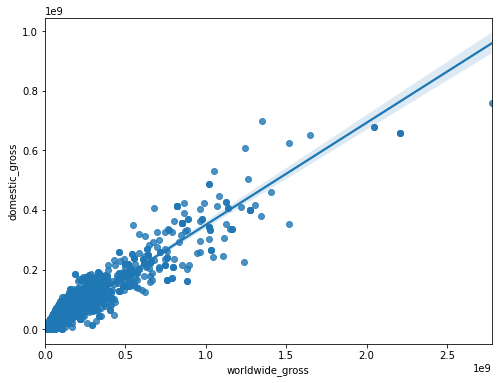

In [72]:
fig, ax1 = plt.subplots(figsize=(8, 6))
sns.regplot(data = master_clean, x ='worldwide_gross', y='domestic_gross', ax=ax1);

# There is a strong correlation between domestic and worldwide gross
# Let's use "worldwide gross" for calculating profit and roi to get a more global estimate.

In [73]:
# Create profit and ROI columns:
master_clean['profit'] = master_clean['worldwide_gross'] - master_clean['production_budget'] 
master_clean['roi'] = ( (master_clean['worldwide_gross'] - master_clean['production_budget'])\
                       / master_clean['production_budget'] )*100


In [74]:
print(master_clean['profit'].median())
print(master_clean['roi'].median())
print(master_clean['production_budget'].quantile(q=(0,.25,.5, .75, 1)))

6597806.0
49.354005
0.00         1400.0
0.25      4500000.0
0.50     16000000.0
0.75     40000000.0
1.00    425000000.0
Name: production_budget, dtype: float64


**Create a categorical variable `roi_profit_bins` using the Median values for ROI and PROFIT as cutoff**:

- high ROI high profit: > 50% > 6.6 M
- high ROI low profit:  > 50% < 6.6 M
- low ROI high profit:  < 50% > 6.6 M
- low ROI low profit:   < 50% < 6.6 M

In [75]:
master_clean['roi_bins'] = master_clean['roi'].map(lambda x: '< 50%'\
                                                   if x<=master_clean['roi'].median() else ('> 50%'))
master_clean['profit_bins'] = master_clean['profit'].map(lambda x: '< 6.6 M'\
                                                         if x<=master_clean['profit'].median() else ('> 6.6 M'))
master_clean['roi_profit_bins'] = master_clean['roi_bins'] + ' ' + master_clean['profit_bins']


**Create a categorical variable `budget_bins` using the 4 quartiles as cutoff**:

- 0-4.5 M (lowest 25% of the data)
- 4.5-16 M (25-50th percentile)
- 16-40 M (50-75th percentile)
- 40-425 M (Top 25% percent)


In [76]:
master_clean['budget_bins'] = pd.qcut(master_clean['production_budget'], q=4,\
                                      labels=['$0-4.5 M', '$4.5-16 M', '$16-40 M', '$40-425 M'])


In [77]:
master_clean.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,director_name,release_date,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,91.0,"Action,Animation,Comedy",1.9,8248.0,Lawrence Kasanoff,2012-12-31,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,$40-425 M
1,tt0293429,Mortal Kombat,NaN,"Action,Adventure,Fantasy",NaN,NaN,Simon McQuoid,1995-08-18,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,$16-40 M
2,tt0326592,The Overnight,88.0,None,7.5,24.0,Jed I. Goodman,2015-06-19,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,$0-4.5 M
3,tt3844362,The Overnight,79.0,"Comedy,Mystery",6.1,14828.0,Patrick Brice,2015-06-19,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,$0-4.5 M
4,tt0337692,On the Road,124.0,"Adventure,Drama,Romance",6.1,37886.0,Walter Salles,2013-03-22,25000000,720828,9313302,2013,-15686698,-62.746792,< 50%,< 6.6 M,< 50% < 6.6 M,$16-40 M


In [78]:
len(master_clean['movie_id'])

3930

In [79]:
'''
MASTER dataset included duplicated entries due to multiple directors. 
Drop these to create another dataset because 
you do not want the same movie repeated for many of your analyses.
'''
master_clean_distinct = master_clean.copy()

In [80]:
master_clean_distinct['movie_id'].duplicated().sum()

431

In [81]:
master_clean_distinct = master_clean_distinct.drop_duplicates(subset='movie_id').reset_index(drop=True)

In [82]:
assert(master_clean_distinct['movie_id'].duplicated().sum() ==0)

In [83]:
len(master_clean_distinct['movie_id'])

3499

In [84]:
success_pivot = master_clean_distinct.pivot_table(index=['roi_profit_bins'],
                                         values=['roi'],
                                         columns=['budget_bins'],
                                         aggfunc=['median','count']) 
success_pivot = success_pivot.style.format("{:.2f}").background_gradient(cmap='Blues', low=0, high=0.75)
success_pivot

#https://towardsdatascience.com/adding-style-to-pandas-in-just-a-few-lines-of-code-be942f65b3a5

**Table shows that:**
- **Low Roi - Low Profit** (Least Successful) movies have more lower budget movies but less loss with higher budgets.
- **Low Roi - High Profit** movies are bigger budget movies only -  bigger room for more profit.
- **High Roi - Low Profit** movies are lower budget movies only -  bigger room for more return on investment. 
- **High Roi - High Profit** (Most Successful) movies have more higher budget movies but ROI gains are more for lower budget movies.

#### WHAT IS THE RELATIONSHIP BETWEEN PROFIT AND ROI FOR DIFFERENT BUDGETS?

In [85]:
# Code copied from: https://stackoverflow.com/questions/61330427/set-y-axis-in-millions and modified a bit. 
# Use the function below to get rid of 1e8s etc on graphs and to format numbers in thousands, millions, etc in visualizations..:

from matplotlib.ticker import FuncFormatter

def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '$%.0f%s' % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])

formatter = FuncFormatter(human_format)

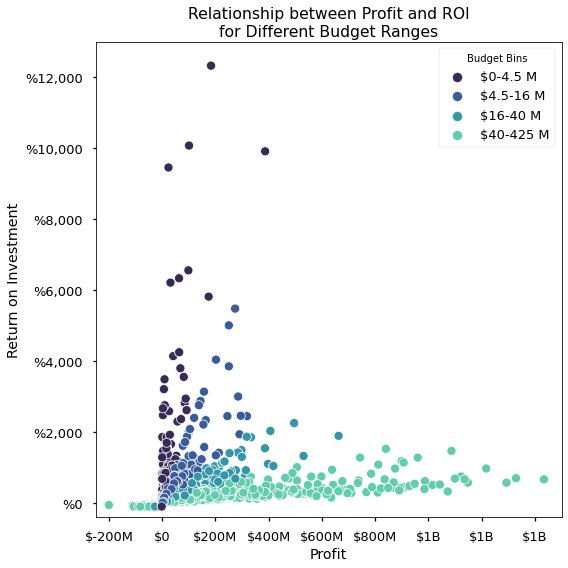

In [86]:
with plt.style.context('seaborn-talk'):
    fig, ax1  = plt.subplots(figsize=(8, 8))
    sns.scatterplot(data=master_clean_distinct, x='profit', y='roi', ax=ax1, hue='budget_bins', palette = "mako")
    
    ax1.set_title('Relationship between Profit and ROI\nfor Different Budget Ranges')
    ax1.set_xlabel("Profit")
    ax1.set_ylabel("Return on Investment")
    legends = ax1.get_legend_handles_labels()[0]
    ax1.legend(title='Budget Bins')

    ax1.set_xlim(-250237650,1500000000) # removing 3 outliers for visualisation
    ax1.set_ylim(-400,13000) # removing 3 outliers for visualisation
    ax1.xaxis.set_major_formatter(formatter)
    ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2000))
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    
    fig.tight_layout()
    fig.savefig('./images/Scatterplot_RoiProfit.png', dpi=300);

* lower than 4.5M Budget : Low profit due to low budget, but high ROI potential. 
* higher than 40M Budget: High profit due to high budget, but low ROI potential. 

ROI is more meaningful for lower budget movies and profit more meaningful for higher budget movies. Use both measures in your future analyses. 


### QUESTION1: WHICH MOVIE GENRES ARE MOST PROFITABLE?

In [87]:
df_genre = master_clean_distinct.copy()

In [88]:
df_genre = df_genre.drop(['runtime_minutes', 'numvotes', 'director_name', 'release_date'], axis=1)

In [89]:
df_genre.head()

,movie_id,primary_title,genres,averagerating,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,"Action,Animation,Comedy",1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,$40-425 M
1,tt0293429,Mortal Kombat,"Action,Adventure,Fantasy",NaN,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,$16-40 M
2,tt0326592,The Overnight,None,7.5,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,$0-4.5 M
3,tt3844362,The Overnight,"Comedy,Mystery",6.1,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,$0-4.5 M
4,tt0337692,On the Road,"Adventure,Drama,Romance",6.1,25000000,720828,9313302,2013,-15686698,-62.746792,< 50%,< 6.6 M,< 50% < 6.6 M,$16-40 M


In [90]:
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3499 entries, 0 to 3498
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   movie_id           3499 non-null   object  
 1   primary_title      3499 non-null   object  
 2   genres             3467 non-null   object  
 3   averagerating      2756 non-null   float64 
 4   production_budget  3499 non-null   int64   
 5   domestic_gross     3499 non-null   int64   
 6   worldwide_gross    3499 non-null   int64   
 7   release_year       3499 non-null   object  
 8   profit             3499 non-null   int64   
 9   roi                3499 non-null   float64 
 10  roi_bins           3499 non-null   object  
 11  profit_bins        3499 non-null   object  
 12  roi_profit_bins    3499 non-null   object  
 13  budget_bins        3499 non-null   category
dtypes: category(1), float64(2), int64(4), object(7)
memory usage: 359.1+ KB


In [91]:
# Dropping the 32 rows where Genre is null. 
df_genre = df_genre.dropna(subset=['genres']).reset_index(drop=True)

Issue: Many movies have **multiple genres**. Seperate them into distict columns to be able to analyze the data:

In [92]:
# In order to investigate seperate genre categories split the genres seperated by commas and expand them into different rows
# df_genre.explode('genres') This function expands to different rows.

df_genre['genres'] = df_genre['genres'].str.split(',')
df_genre = df_genre.explode('genres') # .explode() adds more rows
df_genre.head()

,movie_id,primary_title,genres,averagerating,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,Action,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,$40-425 M
0,tt0249516,Foodfight,Animation,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,$40-425 M
0,tt0249516,Foodfight,Comedy,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,$40-425 M
1,tt0293429,Mortal Kombat,Action,NaN,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,$16-40 M
1,tt0293429,Mortal Kombat,Adventure,NaN,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,$16-40 M


In [93]:
df_genre.info()
# This gives us 7331 data points to work on. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7331 entries, 0 to 3466
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   movie_id           7331 non-null   object  
 1   primary_title      7331 non-null   object  
 2   genres             7331 non-null   object  
 3   averagerating      6224 non-null   float64 
 4   production_budget  7331 non-null   int64   
 5   domestic_gross     7331 non-null   int64   
 6   worldwide_gross    7331 non-null   int64   
 7   release_year       7331 non-null   object  
 8   profit             7331 non-null   int64   
 9   roi                7331 non-null   float64 
 10  roi_bins           7331 non-null   object  
 11  profit_bins        7331 non-null   object  
 12  roi_profit_bins    7331 non-null   object  
 13  budget_bins        7331 non-null   category
dtypes: category(1), float64(2), int64(4), object(7)
memory usage: 809.2+ KB


In [94]:
df_genre.groupby("genres")['movie_id'].count().sort_values()

genres
Reality-TV        1
News              6
Western          24
Musical          27
War              45
Sport            71
Music            85
History          86
Animation       139
Family          178
Fantasy         178
Sci-Fi          224
Biography       231
Mystery         238
Romance         359
Crime           395
Horror          399
Documentary     419
Adventure       471
Thriller        570
Action          655
Comedy          839
Drama          1691
Name: movie_id, dtype: int64

In [95]:
# select those genres which produced at least 50 movies to be able to draw reliable conclusions:
df_genre = df_genre.groupby("genres").filter(lambda x: len(x) > 50) 
df_genre.groupby("genres")['movie_id'].count()

genres
Action          655
Adventure       471
Animation       139
Biography       231
Comedy          839
Crime           395
Documentary     419
Drama          1691
Family          178
Fantasy         178
History          86
Horror          399
Music            85
Mystery         238
Romance         359
Sci-Fi          224
Sport            71
Thriller        570
Name: movie_id, dtype: int64

In [96]:
df_genre.describe().apply(lambda x: x.apply('{0:.0f}'.format))
# The magnitudes are huge, we need format the magnitudes in the visualization

,averagerating,production_budget,domestic_gross,worldwide_gross,profit,roi
count,6147,7228,7228,7228,7228,7228
mean,6,36604089,44765988,108939113,72335024,269
std,1,49075690,76203713,209230107,173951843,1357
min,2,1400,0,0,-200237650,-100
25%,6,5000000,538690,2611750,-2693352,-65
50%,6,18000000,17654912,30628981,10023121,59
75%,7,45000000,53862963,109764978,68729073,253
max,9,425000000,760507625,2776345279,2351345279,41556


Create histograms to see if the continuous variables are normally distributed or skewed:

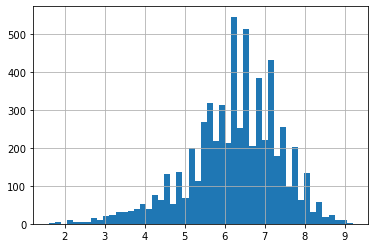

In [97]:
df_genre['averagerating'].hist(bins=50);

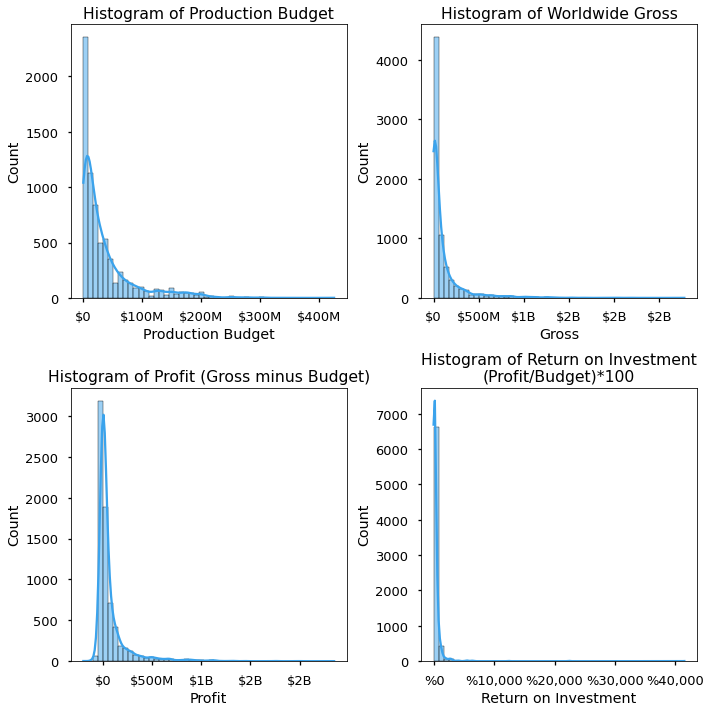

In [98]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4))  = plt.subplots(ncols=2, nrows= 2, figsize=(10, 10))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.histplot(x = df_genre['production_budget'], bins = 50, ax=ax1, kde =True, color =base_color )
    sns.histplot(x = df_genre['worldwide_gross'], bins = 50, ax=ax2, kde =True, color =base_color )
    sns.histplot(x = df_genre['profit'], bins = 50, ax=ax3, kde =True, color =base_color )
    sns.histplot(x = df_genre['roi'], bins = 50, ax=ax4, kde =True, color =base_color )
    
    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_formatter(formatter)
    ax3.xaxis.set_major_formatter(formatter)

    # UserWarning: FixedFormatter should only be used together with FixedLocator
    # Set the locator first before prividing the format:
    ax4.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10000))
    ax4.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) # plt.yticks(rotation=25)
    
    ax1.set_title('Histogram of Production Budget')
    ax2.set_title('Histogram of Worldwide Gross')
    ax3.set_title('Histogram of Profit (Gross minus Budget)')
    ax4.set_title('Histogram of Return on Investment\n(Profit/Budget)*100')

    ax1.set_xlabel("Production Budget")
    ax2.set_xlabel("Gross")
    ax3.set_xlabel("Profit")
    ax4.set_xlabel("Return on Investment")

    fig.tight_layout();
    fig.savefig('./images/Histograms_DependentMeasures.png', dpi=300);
# All of the variables are highly skewed except average rating. 

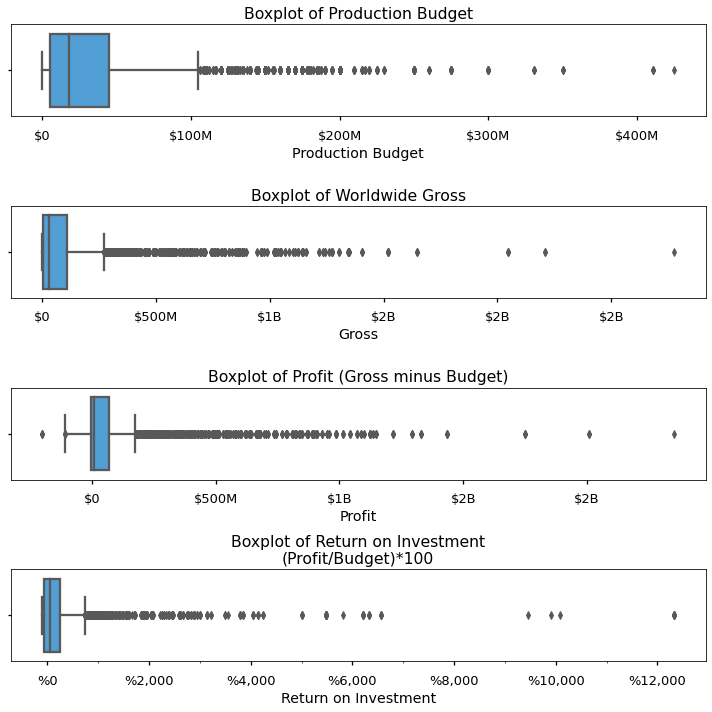

In [99]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1), (ax2),(ax3), (ax4))  = plt.subplots(ncols=1, nrows= 4, figsize=(10, 10))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.boxplot(x = df_genre['production_budget'], ax=ax1, color =base_color )
    sns.boxplot(x = df_genre['worldwide_gross'], ax=ax2, color =base_color )
    sns.boxplot(x = df_genre['profit'], ax=ax3, color =base_color )
    sns.boxplot(x = df_genre[df_genre['roi']<20000]['roi'], ax=ax4, color =base_color )
    
    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_formatter(formatter)
    ax3.xaxis.set_major_formatter(formatter)
    ax4.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2000))
    ax4.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1000))
    ax4.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) # plt.yticks(rotation=25)
    
    ax1.set_title('Boxplot of Production Budget')
    ax2.set_title('Boxplot of Worldwide Gross')
    ax3.set_title('Boxplot of Profit (Gross minus Budget)')
    ax4.set_title('Boxplot of Return on Investment\n(Profit/Budget)*100')

    ax1.set_xlabel("Production Budget")
    ax2.set_xlabel("Gross")
    ax3.set_xlabel("Profit")
    ax4.set_xlabel("Return on Investment")

    fig.tight_layout();
    fig.savefig('./images/Boxplots_DependentMeasures.png', dpi=300);

- All dependent variables are highly skewed except average rating. 
- There are many movies with extremely high budget, gross, profit or roi.
- ROI has the highest skew to the right with the most extreme values. 

In [100]:
# Create 4 different dataframes for each specific budget bin to be able to visualize them separately:
dfbudgets = []
df_original = master_clean_distinct
q= ['$0-4.5 M','$4.5-16 M','$16-40 M','$40-425 M']
for i in range(0,len(q)):
    dfnew = df_original[df_original['budget_bins'] == q[i]]
    dfbudgets.append(dfnew)
    
print(dfbudgets[0].head(2))
print(dfbudgets[1].head(2))

    movie_id  primary_title  runtime_minutes          genres  averagerating  \
2  tt0326592  The Overnight             88.0            None            7.5   
3  tt3844362  The Overnight             79.0  Comedy,Mystery            6.1   

   numvotes   director_name release_date  production_budget  domestic_gross  \
2      24.0  Jed I. Goodman   2015-06-19             200000         1109808   
3   14828.0   Patrick Brice   2015-06-19             200000         1109808   

   worldwide_gross release_year  profit      roi roi_bins profit_bins  \
2          1165996         2015  965996  482.998    > 50%     < 6.6 M   
3          1165996         2015  965996  482.998    > 50%     < 6.6 M   

  roi_profit_bins budget_bins  
2   > 50% < 6.6 M    $0-4.5 M  
3   > 50% < 6.6 M    $0-4.5 M  
     movie_id   primary_title  runtime_minutes                   genres  \
20  tt0403935  Action Jackson            144.0          Action,Thriller   
23  tt0431021  The Possession             92.0  Horror,Mys

Based on 4 different budget ranges create different histograms to see if data is still skewed:

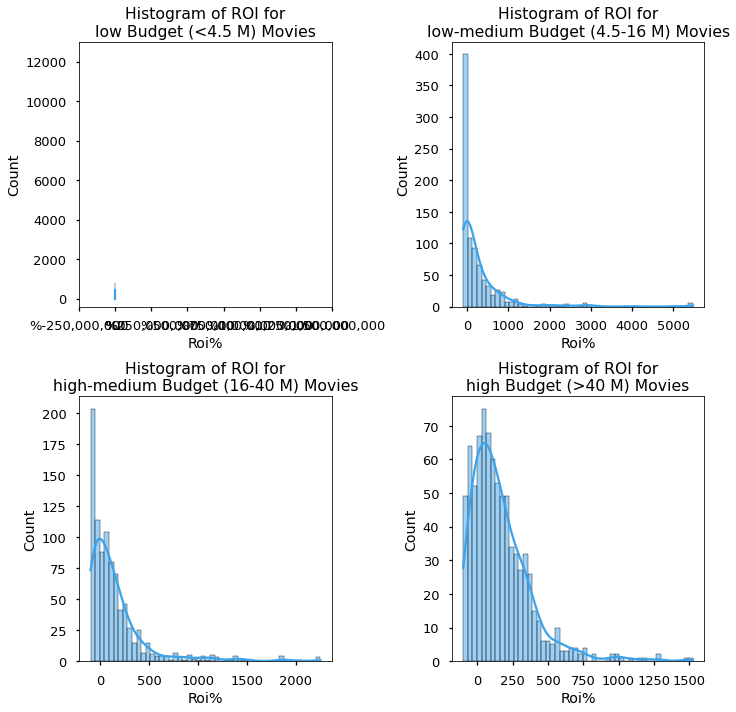

In [101]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4) )  = plt.subplots(ncols=2, nrows= 2, figsize=(10, 10))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.histplot(x = dfbudgets[0]['roi'], bins = 50, ax=ax1, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[1]['roi'], bins = 50, ax=ax2, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[2]['roi'], bins = 50, ax=ax3, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[3]['roi'], bins = 50, ax=ax4, kde =True, color =base_color )
    
    ax1.set_title('Histogram of ROI for\nlow Budget (<4.5 M) Movies')
    ax2.set_title('Histogram of ROI for\nlow-medium Budget (4.5-16 M) Movies')
    ax3.set_title('Histogram of ROI for\nhigh-medium Budget (16-40 M) Movies')
    ax4.set_title('Histogram of ROI for\nhigh Budget (>40 M) Movies')
    
    ax1.set_xlim(-250237650,1500000000) # removing 3 outliers for visualisation
    ax1.set_ylim(-400,13000) # removing 3 outliers for visualisation
    ax1.xaxis.set_major_formatter(formatter)
    ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2000))
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    
    
    ax1.set_xlabel("Roi%")
    ax2.set_xlabel("Roi%")
    ax3.set_xlabel("Roi%")
    ax4.set_xlabel("Roi%")
    
    fig.tight_layout();
# Roi distribution is still highly skewed for the low, low-medium and high-medium 
# It is less skewed for high budget movies. 

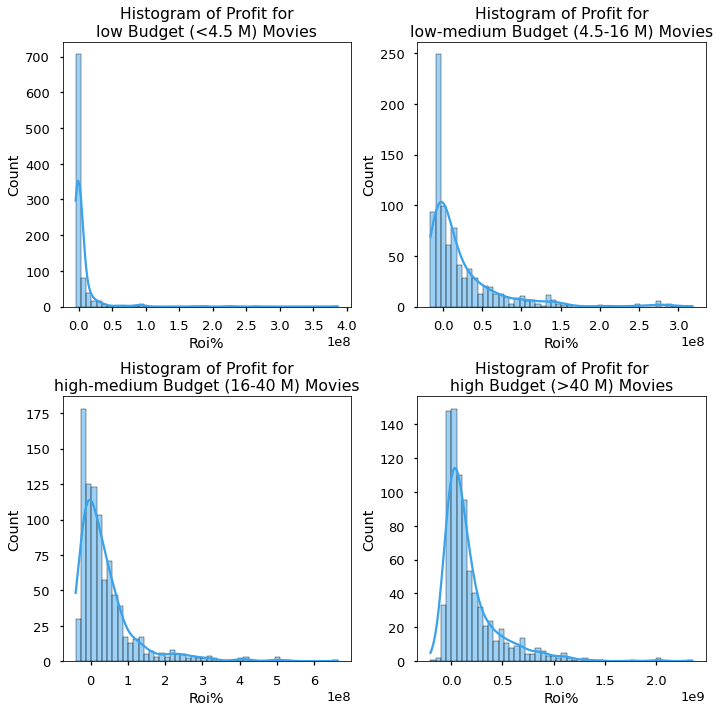

In [102]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4) )  = plt.subplots(ncols=2, nrows= 2, figsize=(10, 10))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.histplot(x = dfbudgets[0]['profit'], bins = 50, ax=ax1, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[1]['profit'], bins = 50, ax=ax2, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[2]['profit'], bins = 50, ax=ax3, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[3]['profit'], bins = 50, ax=ax4, kde =True, color =base_color )
    
    ax1.set_title('Histogram of Profit for\nlow Budget (<4.5 M) Movies')
    ax2.set_title('Histogram of Profit for\nlow-medium Budget (4.5-16 M) Movies')
    ax3.set_title('Histogram of Profit for\nhigh-medium Budget (16-40 M) Movies')
    ax4.set_title('Histogram of Profit for\nhigh Budget (>40 M) Movies')
    
    ax1.set_xlabel("Roi%")
    ax2.set_xlabel("Roi%")
    ax3.set_xlabel("Roi%")
    ax4.set_xlabel("Roi%")
    
    fig.tight_layout();
    
# Profit distribution is highly skewed for the low and low-medium 
# It is more normal for high-medium and high in comparison to ROI. 

In [103]:
# Create a table with mean/median/count values for roi and profit to use in visualisations:
df_genre_table = df_genre.groupby('genres')[['profit', 'roi']].agg(['mean', 'median','count'])
df_genre_table.reset_index(inplace=True)
df_genre_table

genres        profit                            roi                  
                         mean       median count        mean      median count
0        Action  1.204235e+08   28393687.0   655  231.529534   76.968172   655
1     Adventure  2.047587e+08   71306500.0   471  187.487157  131.278815   471
2     Animation  2.235153e+08  133691277.0   139  328.931906  175.320107   139
3     Biography  4.328547e+07    5910210.0   231  317.408067   56.871648   231
4        Comedy  6.889383e+07   14549338.0   839  253.673775   85.954617   839
5         Crime  3.779599e+07    2599159.0   395  122.835674   25.743070   395
6   Documentary  3.411517e+07    1495262.0   419  233.023250   21.545599   419
7         Drama  3.539827e+07    2511317.0  1691  218.409937   30.260742  1691
8        Family  9.632506e+07   18178226.0   178  259.756893   85.018198   178
9       Fantasy  1.419073e+08   28914614.0   178  298.520219   99.294160   178
10      History  3.693972e+07    4270222.5    86   99.815887   34.596546    86
11       Horror  4.513229e+07    4714370.0   399  545.536431   48.345155   399
12        Music  4.162830e+07    3339868.0    85  214.997588   49.166775    85
13      Mystery  5.134784e+07   14199690.0   238  602.710191   96.989125   238
14      Romance  3.391642e+07    5727536.0   359  288.314537   64.194725   359
15       Sci-Fi  1.652511e+08   24006658.5   224  199.494726  119.611842   224
16        Sport  4.484702e+07    -175000.0    71  297.346925   -7.119100    71
17     Thriller  4.884496e+07    2267819.0   570  356.910132   38.061217   570

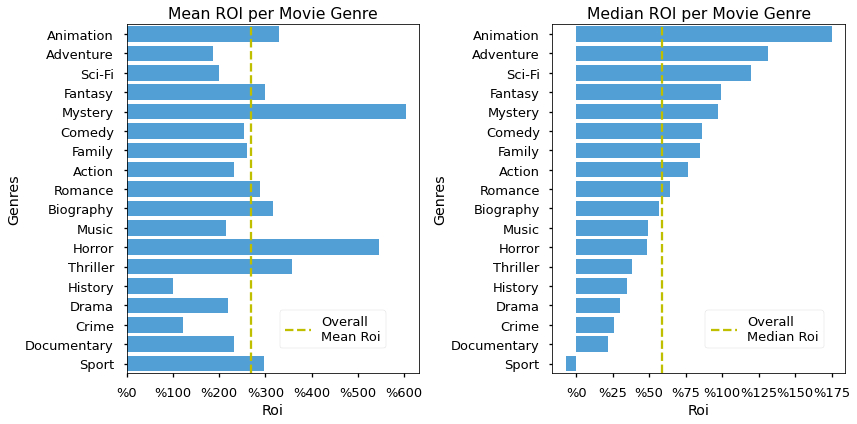

In [104]:
df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette("husl", 9)[6]
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.barplot(x = df_genre_table['roi','mean'], y= df_genre_table['genres'], ax=ax1, color = base_color)
    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'], ax=ax2, color = base_color)

    # Add a line to show the overall mean or median roi values for all movies.
    mean_roi = round(df_genre['roi'].mean())
    median_roi = round(df_genre['roi'].median())
    
    ax1.axvline(x= mean_roi, ymin=0, ymax=1, color='y', linestyle='--', label = "Overall\nMean Roi")  #label = f"Overall Mean Roi= {mean_roi:,.0f}%"
    ax1.legend(bbox_to_anchor = (0.5, 0.2), loc = 'upper left')
    ax2.axvline(x= median_roi, ymin=0, ymax=1, color='y', linestyle='--', label = "Overall\nMedian Roi")
    ax2.legend(bbox_to_anchor = (0.5, 0.2), loc = 'upper left')

    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) # plt.yticks(rotation=25)
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
    ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    
    ax1.set_title('Mean ROI per Movie Genre')
    ax2.set_title('Median ROI per Movie Genre')
    ax1.set_xlabel("Roi")
    ax2.set_xlabel("Roi")
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")

    fig.tight_layout();
    fig.savefig('./images/Barplot_MeanMedian_Roi.png', dpi=300);
     

#### Should we rely on MEAN or MEDIAN?

- The discreancy on the mean versus median roi per genres stem from the outliers present. The value of the mean is distorted by the outliers. 
- There are some really low budget but high profit and ROI movies especailly in the Horror and Mysery genres (think of Paranormal Activity or The Blair Witch Project). It would be hard to make a successful  Animation or Sci-Fi movie on a low budget.
- We should rely on Median rather than mean since it would give us a more realistic and less risky approach. In reality more movies end up being unsuccessful.  

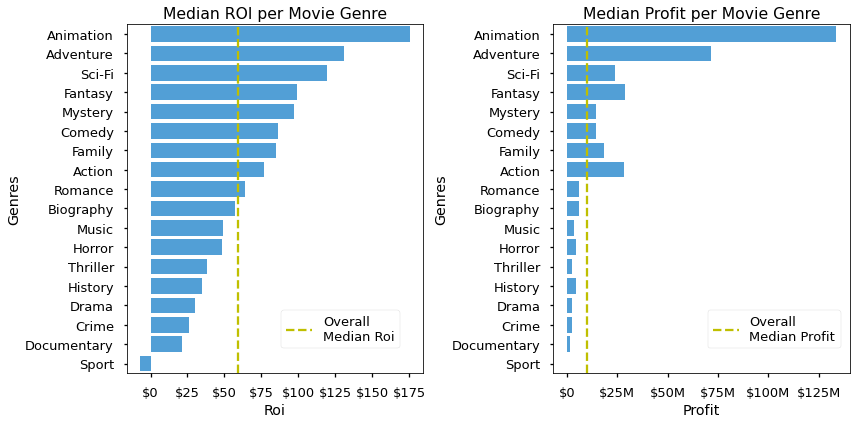

In [105]:
df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)

with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette("husl", 9)[6]
    fig, ( (ax1, ax2)) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'],  ax=ax1, color = base_color)
    sns.barplot(x = df_genre_table['profit','median'], y= df_genre_table['genres'],  ax=ax2, color = base_color)
    
    median_roi = round(df_genre['roi'].median())
    median_profit = round(df_genre['profit'].median())
    
    ax1.axvline(x= median_roi, ymin=0, ymax=1, color='y', linestyle='--', label = "Overall\nMedian Roi")
    ax1.legend(bbox_to_anchor = (0.5, 0.2), loc = 'upper left')
    ax2.axvline(x= median_profit, ymin=0, ymax=1, color='y', linestyle='--', label = "Overall\nMedian Profit")
    ax2.legend(bbox_to_anchor = (0.5, 0.2), loc = 'upper left')
    
    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25000000)) # We want the ticks a little farther apart
    
    ax1.set_title('Median ROI per Movie Genre')
    ax2.set_title('Median Profit per Movie Genre')
    
    ax1.set_xlabel("Roi")
    ax2.set_xlabel("Profit")
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_Median_RoiProfit.png', dpi=300);
     

These graphs more or less overlap, so overall the most profitable two genres are **Animation and Adventure**. 

What **percentage of movies** belong to **high profit & high roi** category in each genre?

Let's also calculate the proportion of high profit & high roi movies in each genre to include into the above summary table:


In [106]:
proportion_highprofitroi = ((df_genre[df_genre['roi_profit_bins']== '> 50% > 6.6 M']\
                             .groupby('genres')['movie_id'].count())*100)\
                            /(df_genre.groupby('genres')['movie_id'].count())

In [107]:
proportion_highprofitroi = pd.DataFrame(data = proportion_highprofitroi)
proportion_highprofitroi = proportion_highprofitroi.reset_index()
proportion_highprofitroi.rename(columns={'movie_id' : 'proportion'}, inplace=True)
proportion_highprofitroi.head()

,genres,proportion
0,Action,53.587786
1,Adventure,64.543524
2,Animation,71.942446
3,Biography,48.051948
4,Comedy,53.277712


In [108]:
# Adding the proportion array into the tabel with a new column named proportion
# You need to make sure index are the same between the two df. 
df_genre_table['proportion'] = proportion_highprofitroi['proportion'] 
df_genre_table

genres        profit                            roi              \
                         mean       median count        mean      median   
2     Animation  2.235153e+08  133691277.0   139  328.931906  175.320107   
1     Adventure  2.047587e+08   71306500.0   471  187.487157  131.278815   
15       Sci-Fi  1.652511e+08   24006658.5   224  199.494726  119.611842   
9       Fantasy  1.419073e+08   28914614.0   178  298.520219   99.294160   
13      Mystery  5.134784e+07   14199690.0   238  602.710191   96.989125   
4        Comedy  6.889383e+07   14549338.0   839  253.673775   85.954617   
8        Family  9.632506e+07   18178226.0   178  259.756893   85.018198   
0        Action  1.204235e+08   28393687.0   655  231.529534   76.968172   
14      Romance  3.391642e+07    5727536.0   359  288.314537   64.194725   
3     Biography  4.328547e+07    5910210.0   231  317.408067   56.871648   
12        Music  4.162830e+07    3339868.0    85  214.997588   49.166775   
11       Horror  4.513229e+07    4714370.0   399  545.536431   48.345155   
17     Thriller  4.884496e+07    2267819.0   570  356.910132   38.061217   
10      History  3.693972e+07    4270222.5    86   99.815887   34.596546   
7         Drama  3.539827e+07    2511317.0  1691  218.409937   30.260742   
5         Crime  3.779599e+07    2599159.0   395  122.835674   25.743070   
6   Documentary  3.411517e+07    1495262.0   419  233.023250   21.545599   
16        Sport  4.484702e+07    -175000.0    71  297.346925   -7.119100   

         proportion  
   count             
2    139  71.942446  
1    471  64.543524  
15   224  54.910714  
9    178  54.494382  
13   238  49.159664  
4    839  53.277712  
8    178  53.370787  
0    655  53.587786  
14   359  45.961003  
3    231  48.051948  
12    85  44.705882  
11   399  45.363409  
17   570  44.210526  
10    86  44.186047  
7   1691  41.277351  
5    395  40.253165  
6    419  37.708831  
16    71  33.802817

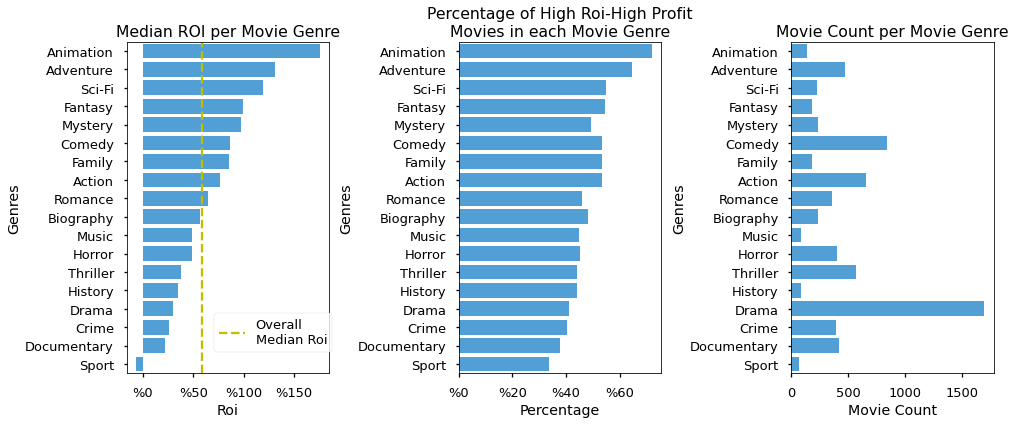

In [109]:
df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette("husl", 9)[6]
    fig, ( (ax1, ax2, ax3) ) = plt.subplots(ncols=3, figsize=(14, 6))

    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'], ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax1.legend(bbox_to_anchor = (0.4, 0.2), loc = 'upper left')
    
    sns.barplot(x = df_genre_table['proportion'], y= df_genre_table['genres'], ax=ax2, color = base_color) 
    sns.barplot(x = df_genre_table['roi','count'], y= df_genre_table['genres'],  ax=ax3, color = base_color)

    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    
    ax1.set_title('Median ROI per Movie Genre')
    ax2.set_title('Percentage of High Roi-High Profit\nMovies in each Movie Genre')
    ax3.set_title('Movie Count per Movie Genre')
    
    ax1.set_xlabel("Roi")
    ax2.set_xlabel("Percentage")
    ax3.set_xlabel("Movie Count")

    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    ax3.set_ylabel("Genres")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_RoiMedianPropCount.png', dpi=300)

Overall the most common genre is **drama** however the most profitable genres are **Animation, Adventure, Sci-Fi, and Fantasy** based on ROI and percentage. 

Let's make specific inferences for each **budget range** about which movie genres are more profitable?

In [110]:
# Define a function to create separate tables for a variable (e.g. roi) for each bin of a different variable (e.g. budget): 
def slicing(df_original, q, var):
    dfbudgets_tables = []
    for i in range(0,len(q)):
        dfnew = df_original[df_original['budget_bins'] == q[i]]
        dfnew = dfnew.groupby("genres").filter(lambda x: len(x) >= 20) 
        dfnew = pd.DataFrame(dfnew.groupby('genres')[var].median()).reset_index()
        dfbudgets_tables.append(dfnew)
    return dfbudgets_tables

In [111]:
df_original = df_genre
q= ['$0-4.5 M','$4.5-16 M','$16-40 M','$40-425 M']
var = 'roi'
dfbudgets_tables_roi = slicing(df_original, q, var)

df_original = df_genre
q= ['$0-4.5 M','$4.5-16 M','$16-40 M','$40-425 M']
var = 'profit'
dfbudgets_tables_profit = slicing(df_original, q, var)

print(dfbudgets_tables_roi[0].head(2))
print(dfbudgets_tables_profit[3].head(2))

      genres        roi
0     Action -99.237486
1  Adventure -98.227900
      genres       profit
0     Action  136246291.5
1  Adventure  213500000.0


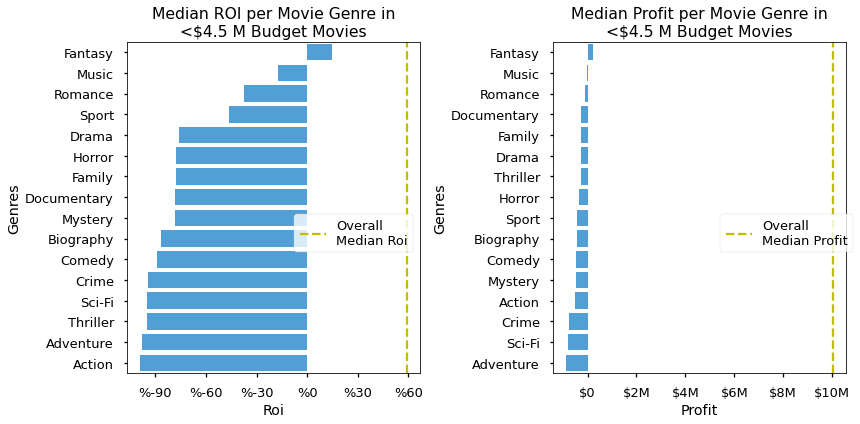

In [112]:
dfbudgets_tables_roi[0] = dfbudgets_tables_roi[0].sort_values(by=('roi'), ascending = False)
dfbudgets_tables_profit[0] = dfbudgets_tables_profit[0].sort_values(by=('profit'), ascending = False)

with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2))  = plt.subplots(ncols=2, figsize=(12, 6))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.barplot(data = dfbudgets_tables_roi[0], x = 'roi', y= 'genres', ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax1.legend(bbox_to_anchor = (0.55, 0.5), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_profit[0], x = 'profit', y= 'genres', ax=ax2, color = base_color) 
    ax2.axvline(x= df_genre['profit'].median(), ymin=0,ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Profit')
    ax2.legend(bbox_to_anchor = (0.55, 0.5), loc = 'upper left')
    
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(30)) # We want the ticks a little farther apart
    ax2.xaxis.set_major_formatter(formatter)
     
    ax1.set_title('Median ROI per Movie Genre in\n<$4.5 M Budget Movies')
    ax2.set_title('Median Profit per Movie Genre in\n<$4.5 M Budget Movies')
      
    ax1.set_xlabel("Roi")
    ax2.set_xlabel("Profit")
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")

    fig.tight_layout();
    fig.savefig('./images/Barplot_RoiProfitbyBudget_1.png', dpi=300);

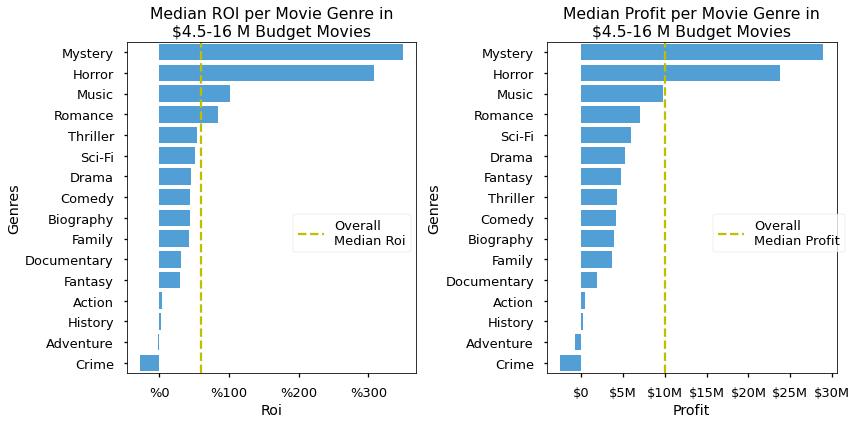

In [113]:
dfbudgets_tables_roi[1] = dfbudgets_tables_roi[1].sort_values(by=('roi'), ascending = False)
dfbudgets_tables_profit[1] = dfbudgets_tables_profit[1].sort_values(by=('profit'), ascending = False)

with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2))  = plt.subplots(ncols=2, figsize=(12, 6))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.barplot(data = dfbudgets_tables_roi[1], x = 'roi', y= 'genres', ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax1.legend(bbox_to_anchor = (0.55, 0.5), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_profit[1], x = 'profit', y= 'genres', ax=ax2, color = base_color) 
    ax2.axvline(x= df_genre['profit'].median(), ymin=0,ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Profit')
    ax2.legend(bbox_to_anchor = (0.55, 0.5), loc = 'upper left')
    
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100)) # We want the ticks a little farther apart
    ax2.xaxis.set_major_formatter(formatter)
     
    ax1.set_title('Median ROI per Movie Genre in\n$4.5-16 M Budget Movies')
    ax2.set_title('Median Profit per Movie Genre in\n$4.5-16 M Budget Movies')
      
    ax1.set_xlabel("Roi")
    ax2.set_xlabel("Profit")
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_RoiProfitbyBudget_2.png', dpi=300);

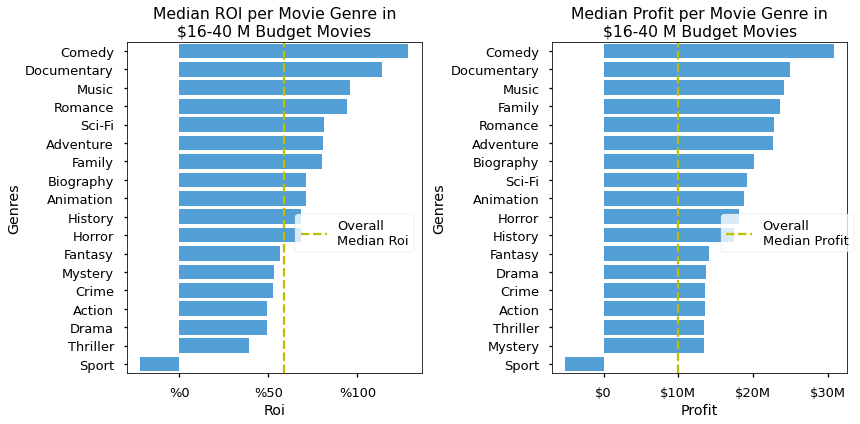

In [114]:
dfbudgets_tables_roi[2] = dfbudgets_tables_roi[2].sort_values(by=('roi'), ascending = False)
dfbudgets_tables_profit[2] = dfbudgets_tables_profit[2].sort_values(by=('profit'), ascending = False)

with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2))  = plt.subplots(ncols=2, figsize=(12, 6))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.barplot(data = dfbudgets_tables_roi[2], x = 'roi', y= 'genres', ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax1.legend(bbox_to_anchor = (0.55, 0.5), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_profit[2], x = 'profit', y= 'genres', ax=ax2, color = base_color) 
    ax2.axvline(x= df_genre['profit'].median(), ymin=0,ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Profit')
    ax2.legend(bbox_to_anchor = (0.55, 0.5), loc = 'upper left')
    
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50)) # We want the ticks a little farther apart
    ax2.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10000000)) # We want the ticks a little farther apart
    
    ax1.set_title('Median ROI per Movie Genre in\n$16-40 M Budget Movies')
    ax2.set_title('Median Profit per Movie Genre in\n$16-40 M Budget Movies')
      
    ax1.set_xlabel("Roi")
    ax2.set_xlabel("Profit")
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_RoiProfitbyBudget_3.png', dpi=300);

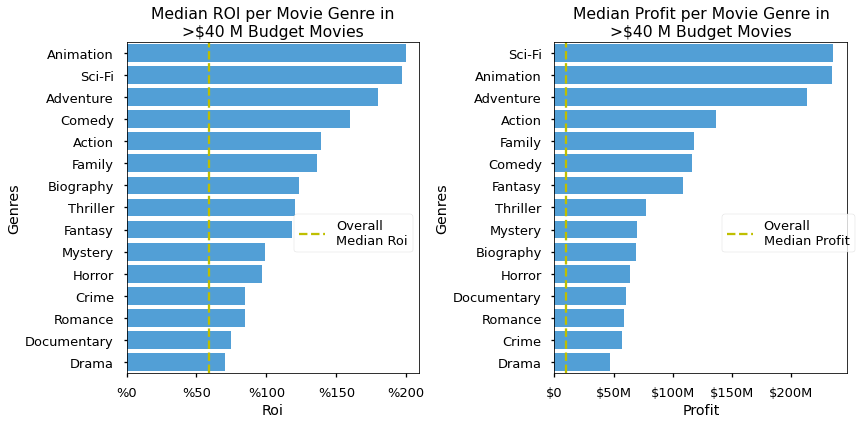

In [115]:
dfbudgets_tables_roi[3] = dfbudgets_tables_roi[3].sort_values(by=('roi'), ascending = False)
dfbudgets_tables_profit[3] = dfbudgets_tables_profit[3].sort_values(by=('profit'), ascending = False)

with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2))  = plt.subplots(ncols=2, figsize=(12, 6))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.barplot(data = dfbudgets_tables_roi[3], x = 'roi', y= 'genres', ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax1.legend(bbox_to_anchor = (0.55, 0.5), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_profit[3], x = 'profit', y= 'genres', ax=ax2, color = base_color) 
    ax2.axvline(x= df_genre['profit'].median(), ymin=0,ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Profit')
    ax2.legend(bbox_to_anchor = (0.55, 0.5), loc = 'upper left')
    
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50)) # We want the ticks a little farther apart
    ax2.xaxis.set_major_formatter(formatter)
    #ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10000000)) # We want the ticks a little farther apart
    
    ax1.set_title('Median ROI per Movie Genre in\n>$40 M Budget Movies')
    ax2.set_title('Median Profit per Movie Genre in\n>$40 M Budget Movies')
      
    ax1.set_xlabel("Roi")
    ax2.set_xlabel("Profit")
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_RoiProfitbyBudget_4.png', dpi=300);

Above visualisations show that:
- Low budget (<4.5 M) movies do not success in general. Avoid if possible. 
- 4.5-16 M budget range should invest on **Mystery and Horror** - for which the movies have a high chance of success with around 300% ROI or making a profit three times as much as the cost: about 20-25 M.
- 16-40 M budget range can invest on **Comedy** and **Documentary** for about a litte over 100% ROI and 20-25 M profit. 
- High budget (>40 M) movies should invest on **Animation, Adventure, Sci-Fi** rather than Mystery and Horror. But  the Return on investment for these higher budget movies are around 200% - profit is twice as much as the cost - less then what Mystery and Horror would bring in the 4.5-16 M range budget. However since the budget is high profit is also very high in these movies: around 200-250 M.  

#### JUST FOR FUN: WHAT IS THE MOST PROFITABLE MOVIE OF ALL TIMES BASED ON ROI?

In [116]:
df_genre['roi'].max()

41556.473999999995

In [117]:
df_genre[df_genre['roi'] == 41556.473999999995]

,movie_id,primary_title,genres,averagerating,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
2277,tt2309260,The Gallows,Horror,4.2,100000,22764410,41656474,2015,41556474,41556.474,> 50%,> 6.6 M,> 50% > 6.6 M,$0-4.5 M
2277,tt2309260,The Gallows,Mystery,4.2,100000,22764410,41656474,2015,41556474,41556.474,> 50%,> 6.6 M,> 50% > 6.6 M,$0-4.5 M
2277,tt2309260,The Gallows,Thriller,4.2,100000,22764410,41656474,2015,41556474,41556.474,> 50%,> 6.6 M,> 50% > 6.6 M,$0-4.5 M


From [wikipedia](https://en.wikipedia.org/wiki/The_Gallows):

"**The Gallows** was released in the United States by Warner Bros. Pictures and New Line Cinema on July 10, 2015. It was largely disliked by critics and audiences but grossed 43 million dollars worldwide against a 100,000 budget. A sequel, The Gallows Act II, was released in October 2019."


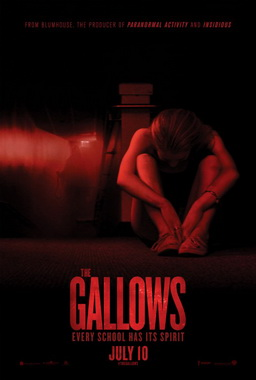

In [118]:
Image(filename='images/The_Gallows_Poster.jpeg')

#### IS THERE A LINK BETWEEN RATING AND ROI? 
#### Can we use movie ratings as a way to assess profitability? 

Create two ROI bins: Below 0 range which makes zero profit, and over 0 range which makes some profit. 

In [119]:
df_rating_roi = master_clean_distinct.copy()

In [120]:
df_rating_roi['roinegpos'] = pd.cut(df_rating_roi['roi'], bins = [-100, 0, 20000], labels=['neg', 'pos'])

In [121]:
# Create dataframes for each bin:
dfroibins = []
df_original = df_rating_roi
q= ['neg',  'pos']
for i in range(0,len(q)):
    dfnew = df_original[df_original['roinegpos'] == q[i]]
    dfroibins.append(dfnew)
print(dfroibins[0].head(1))
print(dfroibins[1].head(1))

    movie_id primary_title  runtime_minutes                   genres  \
0  tt0249516     Foodfight             91.0  Action,Animation,Comedy   

   averagerating  numvotes      director_name release_date  production_budget  \
0            1.9    8248.0  Lawrence Kasanoff   2012-12-31           45000000   

   domestic_gross  worldwide_gross release_year    profit        roi roi_bins  \
0               0            73706         2012 -44926294 -99.836209    < 50%   

  profit_bins roi_profit_bins budget_bins roinegpos  
0     < 6.6 M   < 50% < 6.6 M   $40-425 M       neg  
    movie_id  primary_title  runtime_minutes                    genres  \
1  tt0293429  Mortal Kombat              NaN  Action,Adventure,Fantasy   

   averagerating  numvotes  director_name release_date  production_budget  \
1            NaN       NaN  Simon McQuoid   1995-08-18           20000000   

   domestic_gross  worldwide_gross release_year     profit         roi  \
1        70433227        122133227         

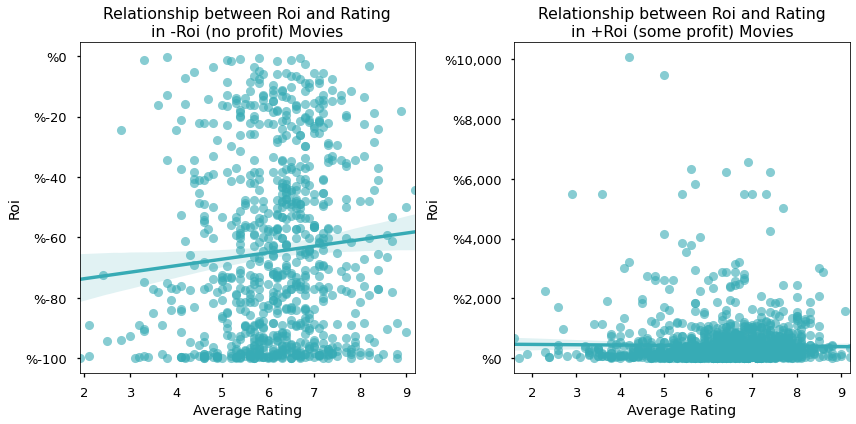

In [122]:
dfroibins[1] = dfroibins[1][dfroibins[1]['roi']<20000] 
# removing 4 outliers from the high roi graph for visualization purposes.

with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2,  figsize=(12, 6))
    
    base_color = sns.color_palette("husl", 9)[5]
    sns.regplot(data=dfroibins[0], x='averagerating', y='roi', ax=ax1, scatter_kws={'alpha':0.6}, color = base_color)
    sns.regplot(data=dfroibins[1], x='averagerating', y='roi', ax=ax2, scatter_kws={'alpha':0.6}, color = base_color)

    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    
    ax1.set_title('Relationship between Roi and Rating\nin -Roi (no profit) Movies')
    ax2.set_title('Relationship between Roi and Rating\nin +Roi (some profit) Movies')

    ax1.set_xlabel("Average Rating")
    ax2.set_xlabel("Average Rating")
    
    ax1.set_ylabel("Roi")
    ax2.set_ylabel("Roi")
    
    fig.tight_layout();
    fig.savefig('./images/Scatterplot_RatingPerRoi.png', dpi=300);
    

- Ratings could be misleading for assessing movie success.
- Do NOT rely on ratings when assessing a movie’s success especially if the movie is making some profit. 

### QUESTION 2: WHICH DIRECTORS SHOULD YOU WORK WITH?

In [123]:
df_director = master_clean.copy()

In [124]:
sum(df_director['director_name'].value_counts() == 1 )
# So many directors with just 1 movie. It would be risky to invest on a director with just 1 movie. 
# Let's not include these directors in the analysis. 

2772

In [125]:
df_director_small = df_director.groupby('director_name').filter(lambda x: len(x) > 3)
# get a subset of the dataset with only those directors with at least 3 movies. 

In [126]:
df_director_table = df_director_small.groupby('director_name')[['roi','profit','production_budget']]\
                                                                                    .agg(['mean', 'count'])
df_director_table.reset_index(inplace=True)
df_director_table

director_name         roi              profit       production_budget  \
                             mean count          mean count              mean   
0          Adam McKay  177.256963     4  7.729204e+07     4        59500000.0   
1       Antoine Fuqua  167.896770     5  9.818346e+07     5        64400000.0   
2   Baltasar Kormákur  179.176662     4  8.102353e+07     4        46500000.0   
3         Brad Peyton  198.920731     5  1.851717e+08     5        79800000.0   
4        Bryan Singer  501.838024     4  4.387683e+08     4       157000000.0   
..                ...         ...   ...           ...   ...               ...   
58        Tyler Perry  133.743819     4  2.840940e+07     4        21500000.0   
59       V.K. Prakash  126.904153     4  1.772390e+07     4        27875000.0   
60         Will Gluck  470.187467     4  1.379407e+08     4        39500000.0   
61        Woody Allen  321.858939     4  7.237239e+07     4        21125000.0   
62        Zack Snyder  124.386352     5  2.941840e+08     5       190000000.0   

          
   count  
0      4  
1      5  
2      4  
3      5  
4      4  
..   ...  
58     4  
59     4  
60     4  
61     4  
62     5  

[63 rows x 7 columns]

In [127]:
# Get a subset of the above table sorted from highest ROI, getting only the top ten directors
df_director_top_roi = df_director_table.sort_values(by=[('roi','mean')], ascending = False).head(10)
df_director_top_roi.reset_index(drop = True, inplace=True)
df_director_top_roi.head()

director_name          roi              profit        \
                              mean count          mean count   
0           James Wan  2500.525402     5  5.737820e+08     5   
1  M. Night Shyamalan  1737.194767     5  1.768319e+08     5   
2  Christopher Landon  1183.776703     4  6.541237e+07     4   
3       Pierre Coffin  1154.617179     4  8.549363e+08     4   
4        Chris Renaud   748.708319     4  5.546959e+08     4   

  production_budget        
               mean count  
0        75300000.0     5  
1        62000000.0     5  
2         8500000.0     4  
3        73500000.0     4  
4        75000000.0     4

In [128]:
df_director_top_profit = df_director_table.sort_values(by=[('profit','mean')], ascending = False).head(10)
df_director_top_profit.reset_index(drop = True, inplace=True)
df_director_top_profit.head()

director_name          roi              profit       production_budget  \
                             mean count          mean count              mean   
0      Pierre Coffin  1154.617179     4  8.549363e+08     4        73500000.0   
1        David Yates   461.484729     5  6.591299e+08     5       162000000.0   
2  Christopher Nolan   313.408898     4  5.840451e+08     4       187500000.0   
3          James Wan  2500.525402     5  5.737820e+08     5        75300000.0   
4        Michael Bay   323.116010     4  5.659996e+08     4       162000000.0   

         
  count  
0     4  
1     5  
2     4  
3     5  
4     4

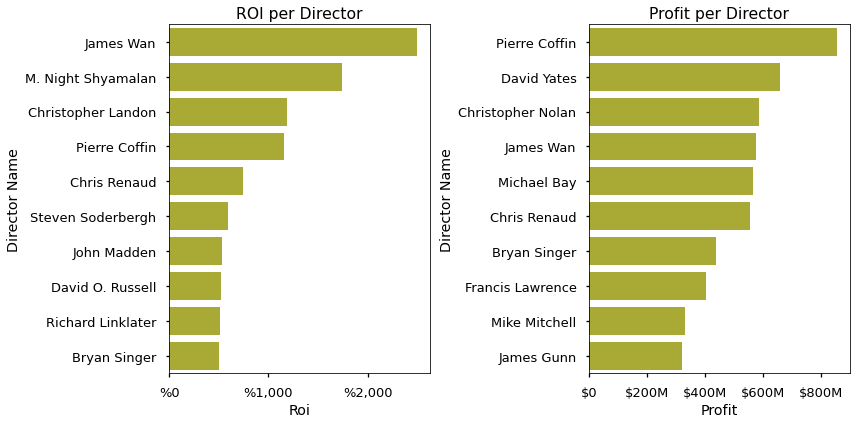

In [129]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    base_color = sns.color_palette()[8]
    
    sns.barplot(y= df_director_top_roi['director_name'], x= df_director_top_roi['roi', 'mean'], color = base_color, ax=ax1)
    sns.barplot(y= df_director_top_profit['director_name'], x= df_director_top_profit['profit', 'mean'],  color = base_color, ax=ax2)

    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1000))
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax2.xaxis.set_major_formatter(formatter)
        
    ax1.set_title('ROI per Director') 
    ax2.set_title("Profit per Director")
    
    ax1.set_xlabel("Roi")
    ax2.set_xlabel("Profit")
    
    
    ax1.set_ylabel("Director Name")
    ax2.set_ylabel("Director Name")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_Directors.png', dpi=300);
    

In [130]:
def commonnames(list1, list2):
    commonlist = []
    for name in list1:
        if name in list2:
            commonlist.append(name) 
    return commonlist

In [131]:
list1 = list(df_director_top_roi['director_name'])
list2 = list(df_director_top_profit['director_name'])
commonnames(list1, list2)

['James Wan', 'Pierre Coffin', 'Chris Renaud', 'Bryan Singer']

4 Common Names between the top 10 directors with highest roi and profit - you can invest on these names with trust:
- **James Wan**
- **Pierre Coffin**
- **Chris Renaud**
- **Bryan Singer**

For at least 1000% ROI invest on: 
- **James Wan**
- **M. Night Shayamalan**
- **Christopher Landon**
- **Pierre Coffin**
    
For at least 550 M profit invest on:
- **Pierre Coffin**
- **David Yates**
- **Christopher Nolan**
- **James Wan**

### QUESTION 3: WHICH MONTHS ARE THE BEST TO RELEASE A MOVIE?

In [132]:
df_months = master_clean_distinct.copy()  

In [133]:
# Extract a new column called release month using the release date. 
df_months['release_month'] =  pd.to_datetime(df_months['release_date']).dt.month

In [134]:
# Order the months so they appear in order from January to December:
df_months.sort_values(by='release_month', inplace=True)

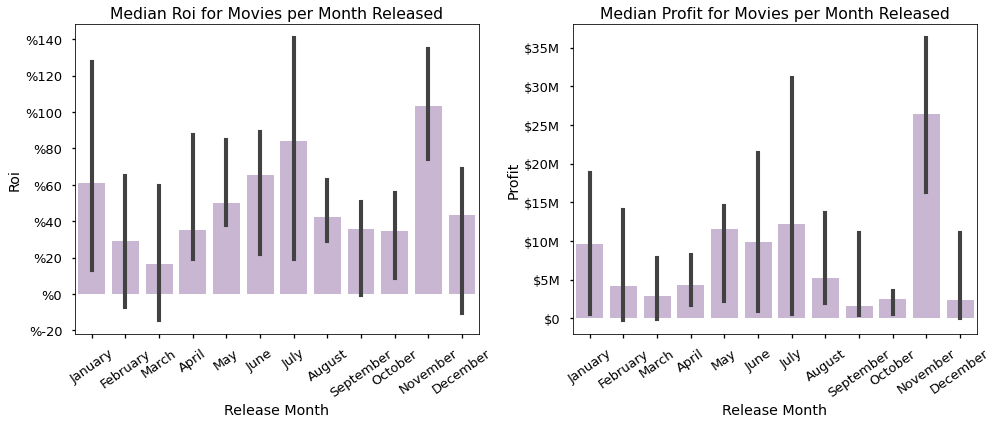

In [135]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    base_color = sns.color_palette("Paired")[8]
    
    sns.barplot(data=df_months, x='release_month', y='roi', estimator= np.median, ax=ax1,  color = base_color)
    sns.barplot(data=df_months, x='release_month', y='profit', estimator= np.median, ax=ax2, color = base_color)
    
    ax1.set_xticklabels(labels = ['January','February','March','April','May','June',\
                                  'July','August','September','October','November','December']\
                                 ,rotation=35)  
    ax2.set_xticklabels(labels = ['January','February','March','April','May','June',\
                                 'July','August','September','October','November','December']\
                                  ,rotation=35)  

    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax2.yaxis.set_major_formatter(formatter)
    
    ax1.set_title('Median Roi for Movies per Month Released')
    ax2.set_title('Median Profit for Movies per Month Released')
    
    ax1.set_xlabel("Release Month")
    ax2.set_xlabel("Release Month")
    
    ax1.set_ylabel("Roi")
    ax2.set_ylabel("Profit")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_ReleaseMonth.png', dpi=300);
    

* High returns on investment as well as profit occur mostly in the month of **November**. This is the safest month to release a movie due to its lower confidence interval as well. People probably go to more movies in the month of November right before the holiday season kicks in and the temperatures start to drop significantly (in the northern hemisphere).  
* Interestingly there is a sharp ***decline*** in ***December*** probably due to the busyness of the holiday season. But **January** - end of holiday season - sees a modest increase again in Roi and Profit. 
* **June and July** is also high in ROI and high in profit. With the high temperatures and the schools being closed people again might be going to the movies more than usual.

### QUESTION 4: WHAT IS A GOOD LENGTH TO AIM FOR A MOVIE?

In [136]:
df_length = master_clean_distinct.copy()  

In [137]:
df_length.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,director_name,release_date,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,91.0,"Action,Animation,Comedy",1.9,8248.0,Lawrence Kasanoff,2012-12-31,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,$40-425 M
1,tt0293429,Mortal Kombat,NaN,"Action,Adventure,Fantasy",NaN,NaN,Simon McQuoid,1995-08-18,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,$16-40 M
2,tt0326592,The Overnight,88.0,None,7.5,24.0,Jed I. Goodman,2015-06-19,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,$0-4.5 M
3,tt3844362,The Overnight,79.0,"Comedy,Mystery",6.1,14828.0,Patrick Brice,2015-06-19,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,$0-4.5 M
4,tt0337692,On the Road,124.0,"Adventure,Drama,Romance",6.1,37886.0,Walter Salles,2013-03-22,25000000,720828,9313302,2013,-15686698,-62.746792,< 50%,< 6.6 M,< 50% < 6.6 M,$16-40 M


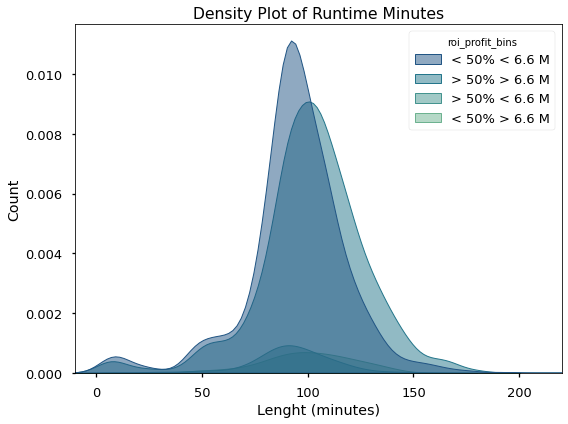

In [138]:
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html

with plt.style.context('seaborn-talk'):
    fig, ax1  = plt.subplots(figsize=(8, 6))
    sns.kdeplot(data = df_length , x = 'runtime_minutes', hue= 'roi_profit_bins', ax=ax1,\
               fill=True, alpha=.5, palette="crest_r", linewidth=1)
    ax1.set_title('Density Plot of Runtime Minutes')
    ax1.set_xlabel("Lenght (minutes)")
    ax1.set_ylabel("Count")
    ax1.set_xlim(-10,220)
    
    fig.tight_layout();
    fig.savefig('./images/kdeplot_RuntimeMinutes.png', dpi=300);

In [139]:
df_length.groupby('roi_profit_bins')['runtime_minutes'].mean() 

roi_profit_bins
< 50% < 6.6 M     94.726182
< 50% > 6.6 M     99.703125
> 50% < 6.6 M     91.801587
> 50% > 6.6 M    102.435237
Name: runtime_minutes, dtype: float64

- There is not a strong effect of runtime minutes. 
- But higher roi and higher profit movies tend to be slightly longer compared to low roi - low profit movies on average. 
- On average a movie in the high roi - high profit bin is **102 minutes** (approximately, 1 hour 40 minutes) long. 

- Let's convert `runtime_minutes` into a categorical variable by binning it. 
- Let's limit it at 200 minutes to avoid outliers. 

In [140]:
df_length['runtime_bins'] = pd.cut(df_length['runtime_minutes'],\
                                   bins=list(range(0, 220, 20)),\
                                   labels=['0-20','20-40','40-60','60-80','80-100',\
                                           '100-120','120-140','140-160','160-180','180-200'])


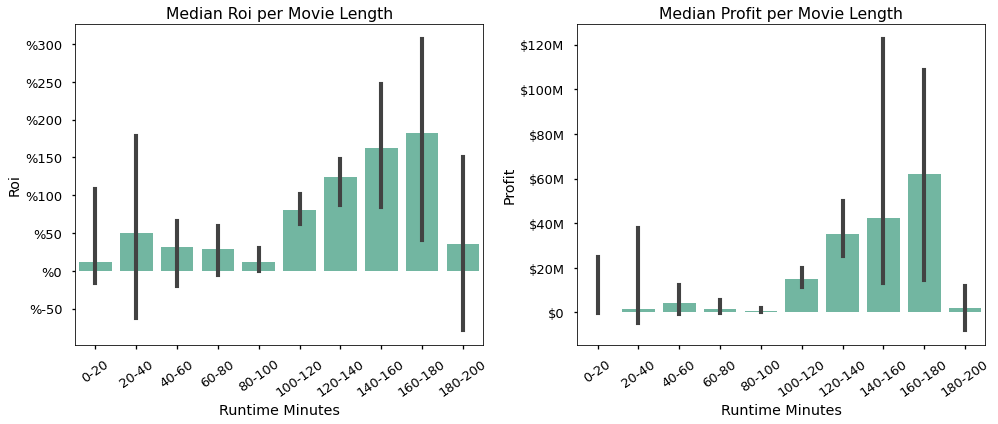

In [141]:
with plt.style.context('seaborn-talk'):
    fig,(ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    base_color = sns.color_palette("Set2")[0]
    sns.barplot(data=df_length, x='runtime_bins', y='roi', estimator = np.median, ci=95, color = base_color, ax=ax1)
    sns.barplot(data=df_length, x='runtime_bins', y='profit', estimator = np.median, ci=95, color = base_color, ax=ax2)
   
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax2.yaxis.set_major_formatter(formatter)
    
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=35)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=35)
    
    ax1.set_title('Median Roi per Movie Length')
    ax2.set_title('Median Profit per Movie Length')
    
    ax1.set_xlabel('Runtime Minutes')
    ax2.set_xlabel('Runtime Minutes')
    
    ax1.set_ylabel('Roi') 
    ax2.set_ylabel('Profit')
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_RuntimeMinutes.png', dpi=300);
    
# The 95% confidence interval is a range of values that you can be 95% confident contains the true mean of the population. 

- If we focus on roi the least risky lenght interval which would maximize roi is **120-160 min**. 
- 160-180 has the potential to bring more roi but it also has the risks of bringing less roi.

- If we focus on profit the least risky lenght interval which would maximaxize profit is **120-140 min**. 
- 140-180 has the potential to bring more profit but it also has the risks of bringing less profit.  

OVERALL: For the most profit and ROI, target **120-140 min** movie lenght. This is a little over 2 hours. 

## Evaluation

There are many reasons why a specific movie becomes successful and there is not one specific recipe. Here I focused on Return on Investment and Profit as means to assess movie profitability. 


## Conclusions

***

#### Which genre is most profitable?:
- For lower budget movies focus on:
    - **HORROR**
    - **MYSTERY** which can bring a high Return on Invesment.
- For high budget movies focus on:
    - **ANIMATION** 
    - **ADVENTURE**
    - **SCI_FI** which can bring a high cash value (profit).

#### Which directors are most profitable?:
For the highest roi and profit, you can invest on these names with trust:
- **James Wan**
- **Pierre Coffin**
- **Chris Renaud**
- **Bryan Singer**

#### Which months are the best to release a movie?:
- Best month to release is: **NOVEMBER**
- If November window is missed then wait intil **January** to release. Do **NOT** release in December. 
- **June and July** are next best options. 

#### Which movie length should be targeted? 
-  For the most profit and ROI, target **120-140 min** movie lenght. This is a little over 2 hours. 

***


## Limitations

- Small sample size - due to lack of budget and gross information. API calls or wed scraping?
- Challenging merging: Movie names not coded the same way in different dataset.
- Lots of outlier movies making the statistical analyses more challenging.
- Need more information about Microsoft’s allocated budget to be able to make more budget specific suggestions. 
***